Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [147]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

import glob

In [148]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [149]:
# Please un-comment it. If you want to delete old data.
#!rm -rf "/content/Skin cancer ISIC The International Skin Imaging Collaboration"

In [150]:
# Loading the Data set
# Please give the path of zipped dataset
!unzip "/content/gdrive/MyDrive/Data Science 2020-21/CNN_assignment.zip"

Archive:  /content/gdrive/MyDrive/Data Science 2020-21/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024

In [151]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [152]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [153]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [154]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [155]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [156]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

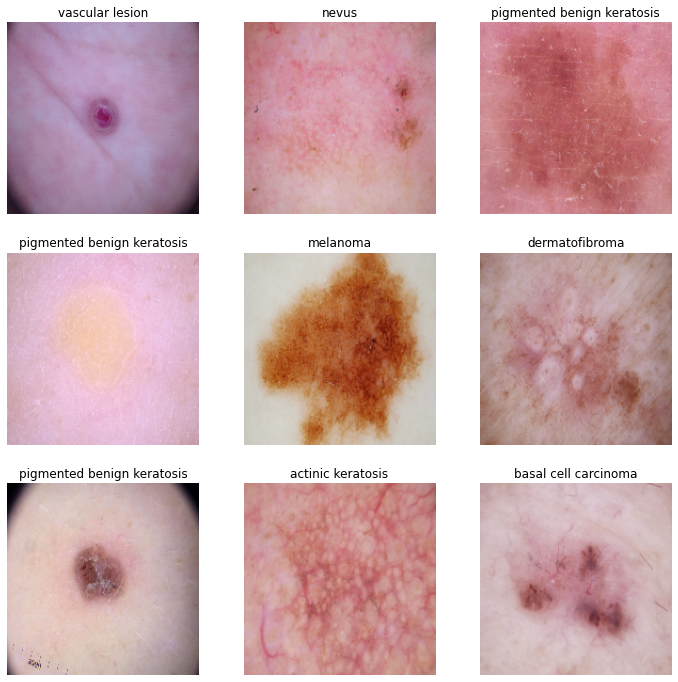

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Please Note: Some times it display repeated class images.

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [158]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

**MODEL 1**

In [159]:
num_classes = 9
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [160]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adamax',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [161]:
# View the summary of all layers
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_15 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 45, 45, 64)      

### Train the model

In [162]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 16s 74ms/step - loss: 2.0852 - accuracy: 0.1811 - val_loss: 2.0033 - val_accuracy: 0.2438
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.9518 - accuracy: 0.3019 - val_loss: 1.7631 - val_accuracy: 0.3803
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7644 - accuracy: 0.3849 - val_loss: 1.6119 - val_accuracy: 0.4519
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5908 - accuracy: 0.4127 - val_loss: 1.5428 - val_accuracy: 0.4541
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5279 - accuracy: 0.4474 - val_loss: 1.5572 - val_accuracy: 0.4609
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4620 - accuracy: 0.4862 - val_loss: 1.4954 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3676 - accuracy: 0.5218 - val_loss: 1.3528 - val_accuracy: 0.5324
Epoch 8/20
5

### Visualizing training results

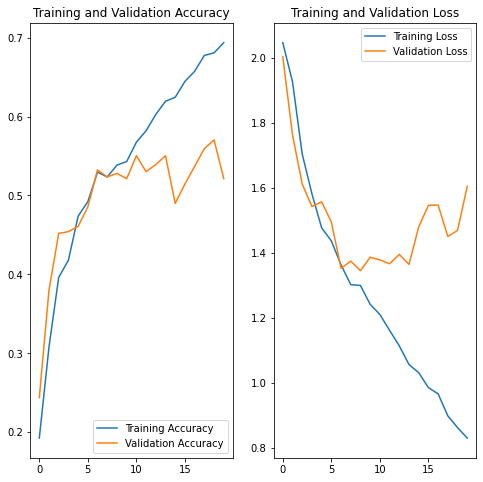

In [163]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

**Observation**: From the above model we can clearly see that our model is getting overfitted.

**So, We will use the layer strartegy because it dosen't require any changes to original dataset.**

In [164]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2,fill_mode="reflect"),
])

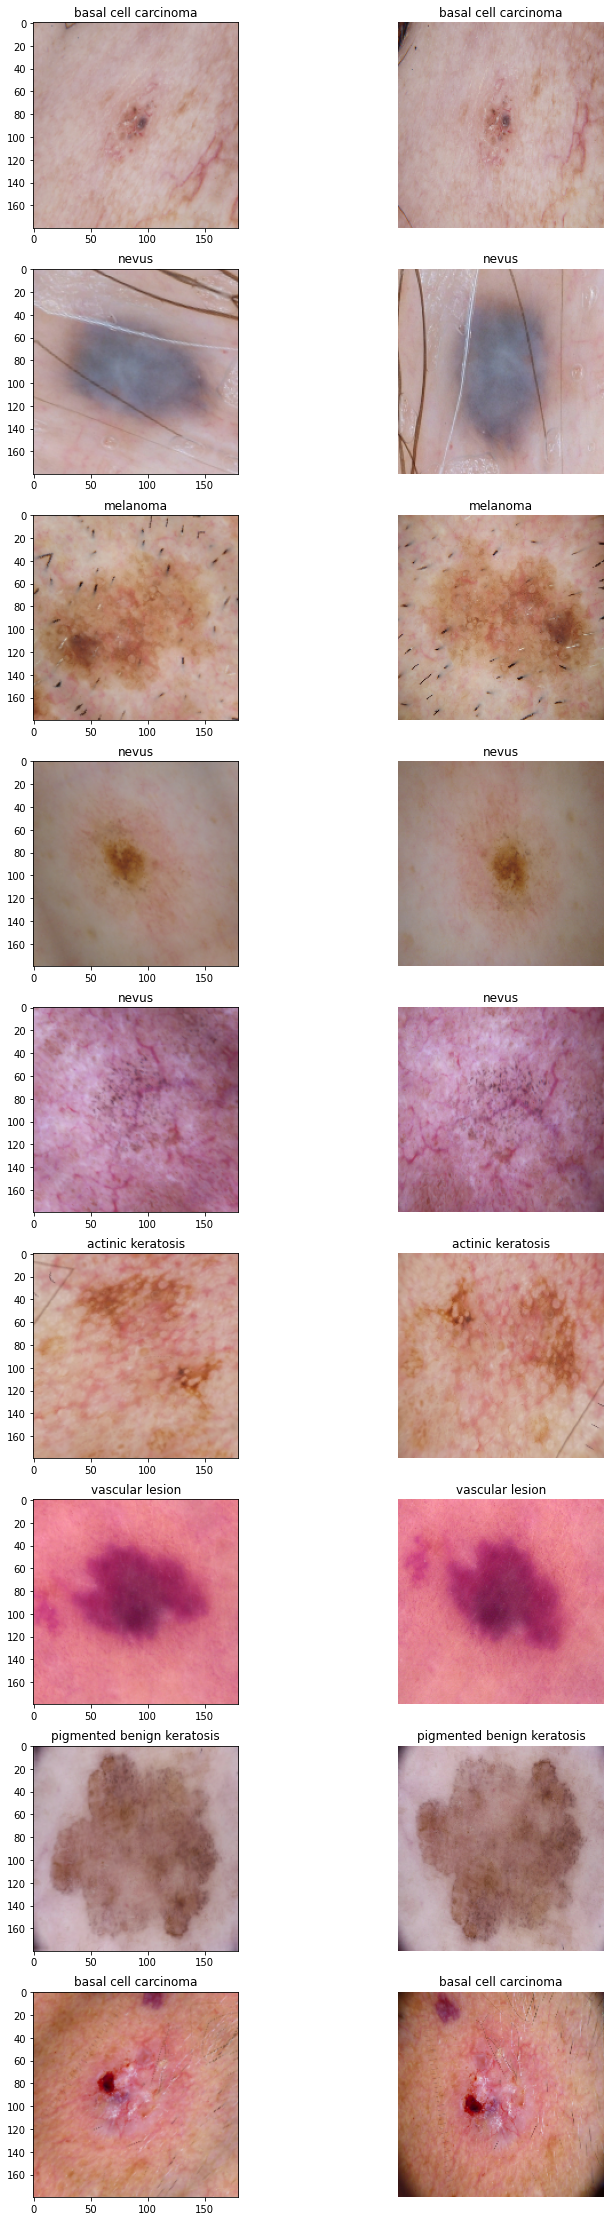

In [165]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 40))
for images, labels in list(train_ds.take(1)):
  augmented_image = data_augmentation(images)
  j=1
  for i in range(9):
    ax = plt.subplot(9, 2, j)
    plt.imshow(augmented_image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    j+=1

    ax = plt.subplot(9, 2, j)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    j+=1

  plt.show()

### Todo:
### Create the model, compile and train the model


**MODEL 2**

In [166]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


### Compiling the model

In [167]:
## Your code goes here
model.compile(optimizer='adamax',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_16 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 45, 45, 32)      

### Training the model

In [168]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 25ms/step - loss: 2.1206 - accuracy: 0.1584 - val_loss: 2.0958 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 2.0149 - accuracy: 0.2178 - val_loss: 1.9815 - val_accuracy: 0.2550
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.8930 - accuracy: 0.2874 - val_loss: 1.8012 - val_accuracy: 0.3535
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.7404 - accuracy: 0.3568 - val_loss: 1.6818 - val_accuracy: 0.3915
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6171 - accuracy: 0.4341 - val_loss: 1.7254 - val_accuracy: 0.4072
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6327 - accuracy: 0.4014 - val_loss: 1.6259 - val_accuracy: 0.4609
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6450 - accuracy: 0.4013 - val_loss: 1.6984 - val_accuracy: 0.4340
Epoch 8/20
56

### Visualizing the results

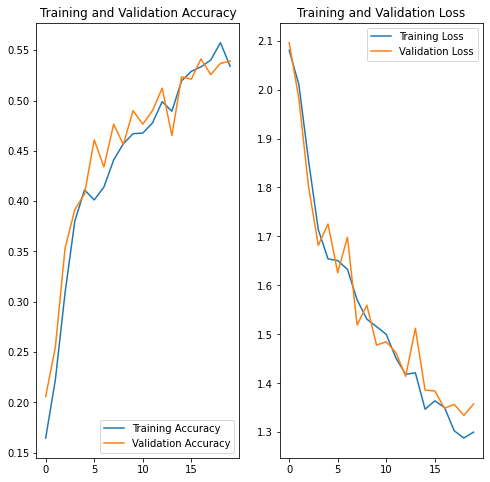

In [169]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Observation after doig data augumentation:-**

---
1- Training accuracy decreases.

2- The training and validation accuracy gap has reduced.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [170]:
## Your code goes here.
df  = []
for i in class_names:
  path_list = [x for x in data_dir_train.glob(i+'/*.jpg')]
  df.append(len(path_list))
df = pd.DataFrame(list(zip(class_names,df)),columns=["class","counts"])
print(df)


                        class  counts
0           actinic keratosis     114
1        basal cell carcinoma     376
2              dermatofibroma      95
3                    melanoma     438
4                       nevus     357
5  pigmented benign keratosis     462
6        seborrheic keratosis      77
7     squamous cell carcinoma     181
8             vascular lesion     139


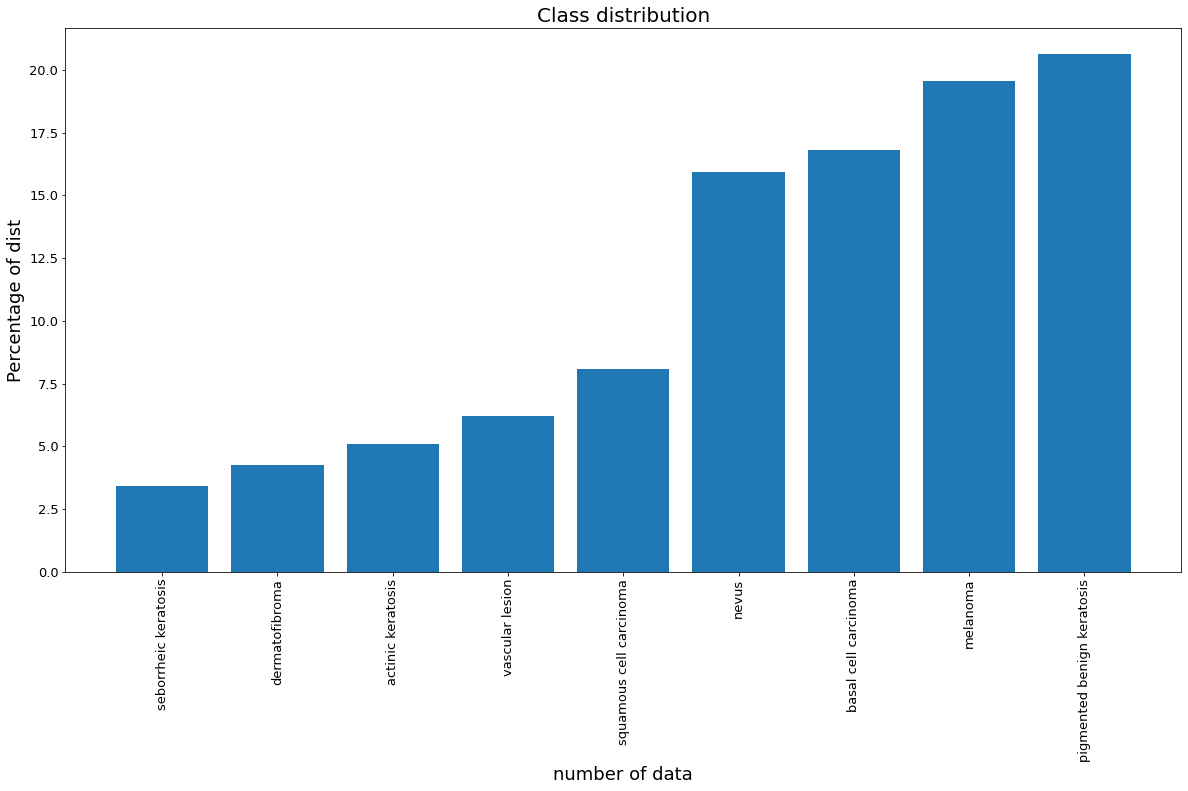

In [171]:
df['counts'] = (df['counts']/sum(df.counts))*100
df.sort_values(by="counts",inplace=True)
plt.figure(figsize=(20,10))
plt.bar(x = df["class"],height=df['counts'])
plt.yticks(fontsize=13)
plt.xlabel('number of data',fontsize = 18)
plt.ylabel('Percentage of dist',fontsize = 18)
plt.title('Class distribution',fontsize=20)
plt.xticks(fontsize = 13,rotation=90)
plt.show()

#### **Todo:** Write your findings here: 

---
#### - Which class has the least number of samples?
Answer: seborrheic keratosis has the least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
Answer: nevus, basal cell carcinoma, melanoma and pigmented benign keratosis dominates the data in terms of proportionate number of sample.


In [172]:
path_list = [x for x in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
print("path_list: ",len(path_list))
lesion_list = [os.path.basename(os.path.dirname(y)) for y in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
print("lesion_list: ",len(lesion_list))
dataframe_dict = dict(zip(path_list, lesion_list))

path_list:  2239
lesion_list:  2239


,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
1,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
2,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
3,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
4,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis
2235,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis
2236,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis
2237,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [173]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [174]:
# Please give the path of training dataset
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEC2E09D750>: 100%|██████████| 500/500 [00:15<00:00, 32.97 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FED1C0376D0>: 100%|██████████| 500/500 [00:15<00:00, 32.09 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FED1C05ACD0>: 100%|██████████| 500/500 [00:15<00:00, 31.26 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FED1AF42F10>: 100%|██████████| 500/500 [01:10<00:00,  7.08 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FEA9C64E950>: 100%|██████████| 500/500 [01:18<00:00,  6.39 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEC2E14BA50>: 100%|██████████| 500/500 [00:15<00:00, 32.05 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FED1A26F250>: 100%|██████████| 500/500 [00:37<00:00, 13.25 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FED7FF82F50>: 100%|██████████| 500/500 [00:15<00:00, 31.77 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FED1A5806D0>:   0%|          | 1/500 [00:00<01:04,  7.73 Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FED1AF42E90>: 100%|██████████| 500/500 [00:15<00:00, 31.95 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [175]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [176]:
path_list = [x for x in data_dir_train.glob(os.path.join( '*','output', '*.jpg'))]
path_list

[PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026265.jpg_4423e009-fc1d-42a8-8221-2fad899e60bd.jpg'),
 PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028646.jpg_1da0a40e-2079-47ce-a052-42fca4c6eaba.jpg'),
 PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027652.jpg_bc2f707b-861e-4c98-a955-231ac1efa2bd.jpg'),
 PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028165.jpg_f6186bc6-1d4c-462e-80e5-cbec9c314968.jpg'),
 PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0

In [177]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob(os.path.join( '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [178]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [179]:
dataframe_dict

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
1,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
2,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
3,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
4,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis
2235,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis
2236,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis
2237,Skin cancer ISIC The International Skin Imagin...,seborrheic keratosis


In [195]:
dataframe_dict = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
dataframe_dict
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = dataframe_dict.append(df2)

In [201]:
new_df.Label.count()

4502

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [182]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [183]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [184]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model

**MODEL 3**

In [185]:
## your code goes here
num_classes = 9
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Note: Added extra layers to imporove model accuracy and also to reduce train and validation difference.

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [186]:
## your code goes here
model.compile(optimizer='adamax',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_17 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 90, 90, 32)        9248      
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 45, 45, 32)      

#### **Todo:**  Train your model

In [187]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 31s 176ms/step - loss: 2.2207 - accuracy: 0.1423 - val_loss: 2.1851 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 30s 174ms/step - loss: 2.1440 - accuracy: 0.1588 - val_loss: 1.8740 - val_accuracy: 0.2502
Epoch 3/30
169/169 [==============================] - 30s 175ms/step - loss: 1.8576 - accuracy: 0.2516 - val_loss: 1.8008 - val_accuracy: 0.3088
Epoch 4/30
169/169 [==============================] - 30s 174ms/step - loss: 1.7606 - accuracy: 0.3045 - val_loss: 1.6135 - val_accuracy: 0.4113
Epoch 5/30
169/169 [==============================] - 30s 175ms/step - loss: 1.6217 - accuracy: 0.3696 - val_loss: 1.5947 - val_accuracy: 0.3734
Epoch 6/30
169/169 [==============================] - 30s 175ms/step - loss: 1.5666 - accuracy: 0.3915 - val_loss: 1.4640 - val_accuracy: 0.4447
Epoch 7/30
169/169 [==============================] - 30s 174ms/step - loss: 1.4689 - accuracy: 0.4321 - val_loss: 1.4160 - val_ac

#### **Todo:**  Visualize the model results

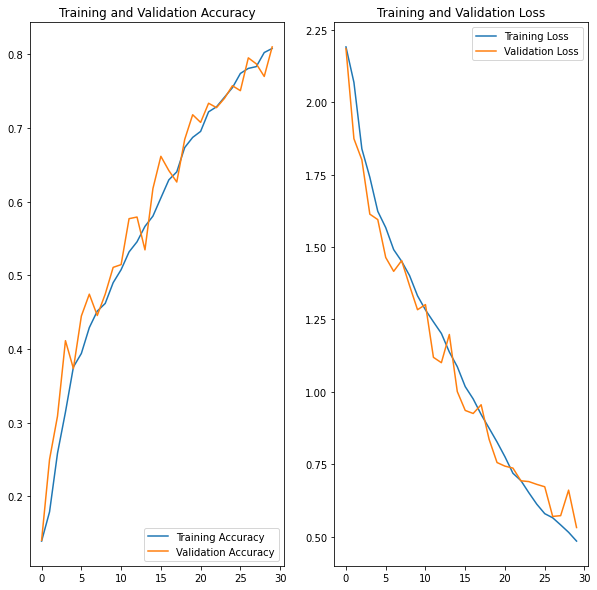

In [188]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Create your model (make sure to include normalization)

**MODEL 4**

In [189]:
num_classes = 9
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [190]:
model.compile(optimizer='adamax',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_18 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 90, 90, 32)        9248      
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 90, 90, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 90, 90, 32)      

In [191]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 31s 176ms/step - loss: 3.5216 - accuracy: 0.1720 - val_loss: 14.7444 - val_accuracy: 0.1366
Epoch 2/30
169/169 [==============================] - 31s 177ms/step - loss: 1.9255 - accuracy: 0.2820 - val_loss: 19.5096 - val_accuracy: 0.1500
Epoch 3/30
169/169 [==============================] - 30s 175ms/step - loss: 1.7398 - accuracy: 0.3624 - val_loss: 17.1013 - val_accuracy: 0.1715
Epoch 4/30
169/169 [==============================] - 30s 175ms/step - loss: 1.6095 - accuracy: 0.3912 - val_loss: 5.5390 - val_accuracy: 0.2880
Epoch 5/30
169/169 [==============================] - 31s 177ms/step - loss: 1.5160 - accuracy: 0.4296 - val_loss: 7.1809 - val_accuracy: 0.3014
Epoch 6/30
169/169 [==============================] - 31s 176ms/step - loss: 1.4542 - accuracy: 0.4380 - val_loss: 5.7145 - val_accuracy: 0.3155
Epoch 7/30
169/169 [==============================] - 30s 175ms/step - loss: 1.4192 - accuracy: 0.4599 - val_loss: 7.2130 - val

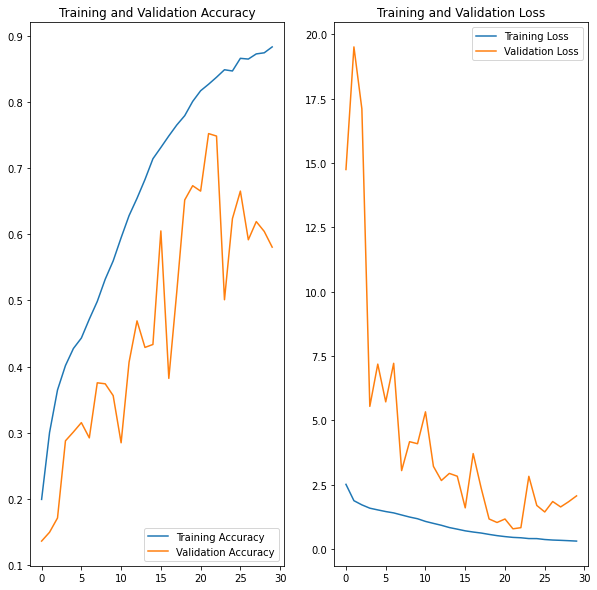

In [192]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Question 1:  Did we get rid of the overfitting?

---
Answer: Yes, after adding dropouts, augomentation(rebalance) and using batch normalization.

Question 2: Did class rebalance help?

---
Answer: Yes, rebalancing help in increasing the model accuracy.


**MODEL DEATILS**

**Model 1: Basic model**

Accuracy: around 70%

Val. Accuracy: around 50%


---
**Model 2: Basic model + dropouts**

Accuracy: around 50%

Val. Accuracy: around 50%

---
**Model 3: Basic model + dropouts + rebalancing**

Accuracy: around 80%

Val. Accuracy: around 80%


---

**Model 4: Basic model + dropouts + rebalancing + batch normalization**

Accuracy: around 90%

Val. Accuracy: around 60%

So, according to my analysis **MODEL 3 (Basic model + dropouts + rebalancing)** is a good model. And I will procede with model 3 because the difference between training and validation set is less and accuracy is acceptable.